In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from utility import mask2rle, rle2mask
from dataset import ShiptDetectionDataset, TestDataset

### Read label data

In [2]:
label_file = "/mnt/data/psemchyshyn/ship-detection-data/train_ship_segmentations_v2.csv"
masks = pd.read_csv(label_file)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### Distribution of ships in the images

In [3]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: int(isinstance(c_row, str)))
image_ships = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
image_ships['has_ship'] = image_ships['ships'].map(lambda x: x > 0 )
image_ships['has_ship'].value_counts()

False    150000
True      42556
Name: has_ship, dtype: int64

Text(0, 0.5, 'Count')

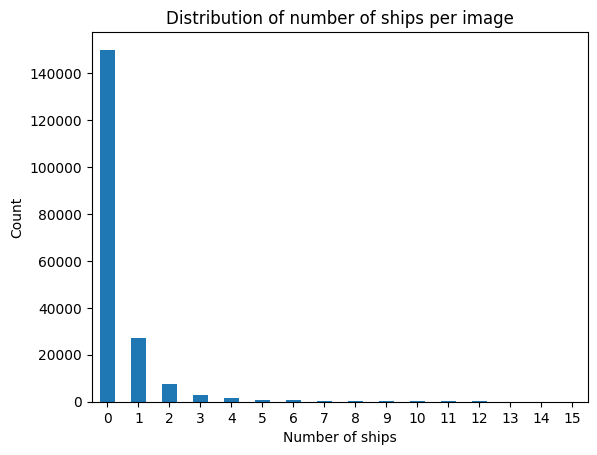

In [4]:
image_ships.groupby("ships").agg({"ImageId": "count"}).plot.bar(legend=None)
plt.title("Distribution of number of ships per image")
plt.xticks(rotation=0)
plt.xlabel("Number of ships")
plt.ylabel("Count")

### Masks shape

In [5]:
train_img_folder = "/mnt/data/psemchyshyn/ship-detection-data/train_v2"

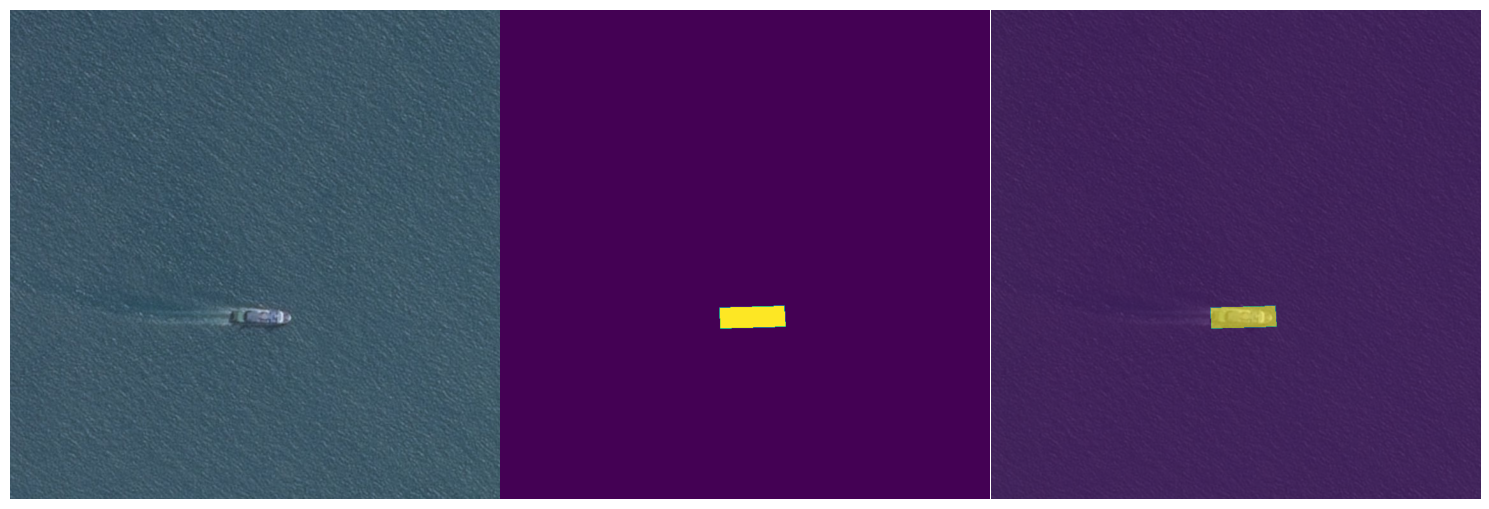

In [6]:
example_id = "000155de5.jpg"
example_image = np.asarray(Image.open(f"{train_img_folder}/{example_id}"))
image_shape = example_image.shape[:2]

example_image_ships = masks.loc[masks['ImageId'] == example_id, 'EncodedPixels'].tolist()

example_masks = np.zeros(image_shape)
for mask in example_image_ships:
    example_masks += rle2mask(mask, shape=image_shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 40))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(example_image)
ax[1].imshow(example_masks)
ax[2].imshow(example_image)
ax[2].imshow(example_masks, alpha=0.6)
plt.tight_layout(h_pad=0.1, w_pad=0.1) # to adjust automatically axis to subplot area
plt.show()

In [7]:
masks_with_ship = masks[masks["ships"] == 1]
ratios = []
for idx, row in masks_with_ship.iterrows():
    ship_to_image_ratio = rle2mask(row["EncodedPixels"], shape=(image_shape[0], image_shape[1])).sum() / (image_shape[0]*image_shape[1])
    ratios.append(ship_to_image_ratio)

print(f"Average space ship takes in the image: {np.mean(ratios) * 100} %")

Average space ship takes in the image: 0.26574077159411275 %


Len of the train ds 6808


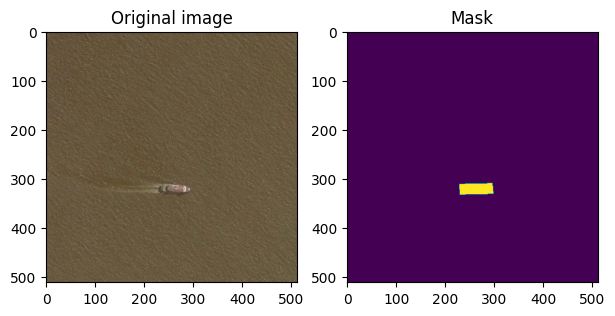

In [16]:
ds = ShiptDetectionDataset(train_img_folder, label_file, 512, 512, reduce=0.1, balance=True)

print(f"Len of the train ds {len(ds)}")

results = ds[0]
img = results["image"]
mask = results["mask"]

img = img.squeeze()
mask = mask.squeeze()

plt.figure(figsize=(11, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Mask')
plt.savefig(f"example.png")